# 2015 Heart Attack Analysis
### By: Varun Arvind

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  plot_confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)

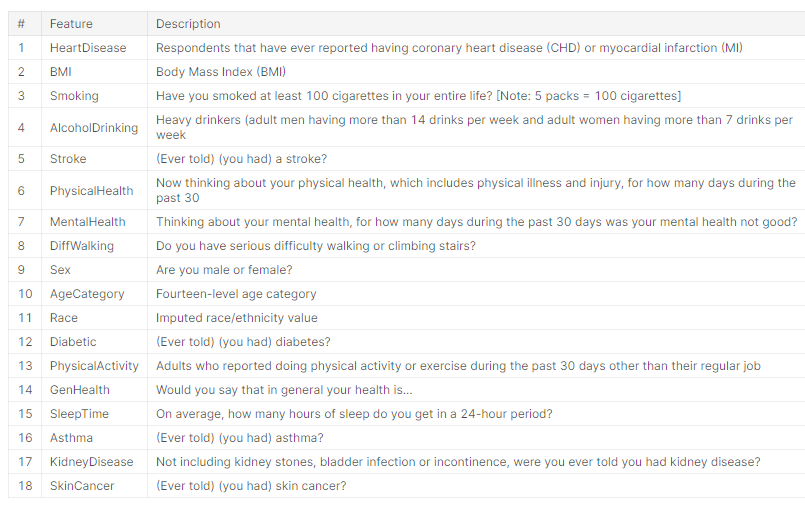

# Load in Dataset

In [49]:
brfss_2015_dataset = pd.read_csv('2015.csv')

# Preprocessing/Feature Engineering

In [50]:
brfss_df_selected = brfss_2015_dataset[['_MICHD', 
                                         '_RFHYPE5',  
                                         '_BMI5', 
                                         'SMOKE100', 
                                         'CVDSTRK3', 'DIABETE3', 
                                         '_TOTINDA', 
                                         '_RFDRHV5', 
                                         'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 
                                         'SEX', '_AGEG5YR']]

In [51]:
brfss_df_selected = brfss_df_selected.dropna()

In [52]:
brfss_df_selected['_MICHD'] = brfss_df_selected['_MICHD'].replace({2: 0})

In [53]:
brfss_df_selected['_BMI5'] = brfss_df_selected['_BMI5'].div(100).round(0)

In [54]:
#SMOKE100 (Smoking)
# Change 2 to 0 because it is No
# Remove all 7 (dont knows)
# Remove all 9 (refused)
brfss_df_selected['SMOKE100'] = brfss_df_selected['SMOKE100'].replace({2:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected.SMOKE100 != 7]
brfss_df_selected = brfss_df_selected[brfss_df_selected.SMOKE100 != 9]


In [55]:
#CVDSTRK3 (Stroke)
# Change 2 to 0 because it is No
# Remove all 7 (dont knows)
# Remove all 9 (refused)
brfss_df_selected['CVDSTRK3'] = brfss_df_selected['CVDSTRK3'].replace({2:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected.CVDSTRK3 != 7]
brfss_df_selected = brfss_df_selected[brfss_df_selected.CVDSTRK3 != 9]


In [56]:
#DIABETE3 (Diabetes)
# 0 is for no diabetes or only during pregnancy, 1 is for pre-diabetes or borderline diabetes, 2 is for yes diabetes
# Remove all 7 (dont knows)
# Remove all 9 (refused)
brfss_df_selected['DIABETE3'] = brfss_df_selected['DIABETE3'].replace({2:0, 3:0, 1:2, 4:1})
brfss_df_selected = brfss_df_selected[brfss_df_selected.DIABETE3 != 7]
brfss_df_selected = brfss_df_selected[brfss_df_selected.DIABETE3 != 9]


In [57]:
#_TOTINDA (Physical Activity)
# 1 for physical activity and 0 is no physical activity
# change 2 to 0 for no physical activity
# Remove all 9 (don't know/refused)
brfss_df_selected['_TOTINDA'] = brfss_df_selected['_TOTINDA'].replace({2:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected._TOTINDA != 9]


In [58]:
#_RFDRHV5 (Heavy Drinking)
# Change 1 to 0 (1 was no for heavy drinking). change all 2 to 1 (2 was yes for heavy drinking)
# remove all dont knows and missing 9
brfss_df_selected['_RFDRHV5'] = brfss_df_selected['_RFDRHV5'].replace({1:0, 2:1})
brfss_df_selected = brfss_df_selected[brfss_df_selected._RFDRHV5 != 9]


In [59]:
#GENHLTH
# (1 is Excellent -> 5 is Poor)
# Remove 7 and 9 for don't know and refused
brfss_df_selected = brfss_df_selected[brfss_df_selected.GENHLTH != 7]
brfss_df_selected = brfss_df_selected[brfss_df_selected.GENHLTH != 9]


In [60]:
#MENTHLTH
# already in days so keep that, scale will be 0-30
# change 88 to 0 because it means none (no bad mental health days)
# remove 77 and 99 for don't know not sure and refused
brfss_df_selected['MENTHLTH'] = brfss_df_selected['MENTHLTH'].replace({88:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected.MENTHLTH != 77]
brfss_df_selected = brfss_df_selected[brfss_df_selected.MENTHLTH != 99]


In [61]:
#PHYSHLTH
# already in days so keep that, scale will be 0-30
# change 88 to 0 because it means none (no bad mental health days)
# remove 77 and 99 for don't know not sure and refused
brfss_df_selected['PHYSHLTH'] = brfss_df_selected['PHYSHLTH'].replace({88:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected.PHYSHLTH != 77]
brfss_df_selected = brfss_df_selected[brfss_df_selected.PHYSHLTH != 99]


In [62]:
#DIFFWALK
# change 2 to 0 for no. 1 is already yes
# remove 7 and 9 for don't know not sure and refused
brfss_df_selected['DIFFWALK'] = brfss_df_selected['DIFFWALK'].replace({2:0})
brfss_df_selected = brfss_df_selected[brfss_df_selected.DIFFWALK != 7]
brfss_df_selected = brfss_df_selected[brfss_df_selected.DIFFWALK != 9]


In [63]:
#18 SEX
# female is 0 and male is 1
# change 2 to 0 (female as 0). 
brfss_df_selected['SEX'] = brfss_df_selected['SEX'].replace({2:0})


In [64]:
#19 _AGEG5YR
# 1 is 18-24 all the way up to 13 wis 80 and older. 5 year increments.
# remove 14 because it is don't know or missing
brfss_df_selected = brfss_df_selected[brfss_df_selected._AGEG5YR != 14]


In [65]:
brfss = brfss_df_selected.rename(columns = {'_MICHD':'HeartDiseaseorAttack', 
                                         '_BMI5':'BMI', 
                                         'SMOKE100':'Smoker', 
                                         'CVDSTRK3':'Stroke', 'DIABETE3':'Diabetes', 
                                         '_TOTINDA':'PhysActivity', 
                                         '_RFDRHV5':'HvyAlcoholConsump', 
                                         'GENHLTH':'GenHlth', 'MENTHLTH':'MentHlth', 'PHYSHLTH':'PhysHlth', 'DIFFWALK':'DiffWalk', 
                                         'SEX':'Sex', '_AGEG5YR':'Age'})


In [66]:
brfss_ml_2015 = brfss[['HeartDiseaseorAttack', 'BMI', 'Smoker', 'GenHlth', 'HvyAlcoholConsump', 'Stroke', 'PhysHlth', 'MentHlth', 'DiffWalk', 'Sex', 'Age', 'PhysActivity', 'Diabetes']]

In [67]:
brfss_ml_2015

,HeartDiseaseorAttack,BMI,Smoker,GenHlth,HvyAlcoholConsump,Stroke,PhysHlth,MentHlth,DiffWalk,Sex,Age,PhysActivity,Diabetes
0,0.0,40.0,1.0,5.0,0.0,0.0,15.0,18.0,1.0,0.0,9.0,0.0,0.0
1,0.0,25.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0
3,0.0,28.0,0.0,5.0,0.0,0.0,30.0,30.0,1.0,0.0,9.0,0.0,0.0
4,0.0,24.0,0.0,5.0,0.0,0.0,20.0,0.0,0.0,0.0,9.0,0.0,0.0
5,0.0,27.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
441450,0.0,45.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,1.0,5.0,0.0,0.0
441451,0.0,18.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,2.0
441452,0.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
441454,0.0,23.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0


## Correlation/Heatmap

In [22]:
brfss_ml_2015.corr()

,HeartDiseaseorAttack,BMI,Smoker,GenHlth,HvyAlcoholConsump,Stroke,PhysHlth,MentHlth,DiffWalk,Sex,Age,PhysActivity,Diabetes
HeartDiseaseorAttack,1.000000,0.054425,0.109605,0.250784,-0.028395,0.206799,0.181877,0.059430,0.215051,0.071406,0.226595,-0.084493,0.185597
BMI,0.054425,1.000000,0.020443,0.225568,-0.043465,0.021728,0.117314,0.075808,0.190190,0.043569,-0.003339,-0.134856,0.219811
Smoker,0.109605,0.020443,1.000000,0.162726,0.107360,0.059813,0.116864,0.097847,0.121200,0.100770,0.118171,-0.086191,0.061908
GenHlth,0.250784,0.225568,0.162726,1.000000,-0.031809,0.173991,0.517288,0.294624,0.450964,-0.012167,0.164805,-0.260917,0.289740
HvyAlcoholConsump,-0.028395,-0.043465,0.107360,-0.031809,1.000000,-0.016922,-0.024142,0.032582,-0.038283,0.016348,-0.046809,0.010346,-0.056640
Stroke,0.206799,0.021728,0.059813,0.173991,-0.016922,1.000000,0.146373,0.067159,0.178736,-0.003693,0.137216,-0.068379,0.110940
PhysHlth,0.181877,0.117314,0.116864,0.517288,-0.024142,0.146373,1.000000,0.347990,0.474101,-0.045798,0.111339,-0.208683,0.176665
MentHlth,0.059430,0.075808,0.097847,0.294624,0.032582,0.067159,0.347990,1.000000,0.222306,-0.073201,-0.099972,-0.115218,0.063726
DiffWalk,0.215051,0.190190,0.121200,0.450964,-0.038283,0.178736,0.474101,0.222306,1.000000,-0.075639,0.225674,-0.245245,0.227726
Sex,0.071406,0.043569,0.100770,-0.012167,0.016348,-0.003693,-0.045798,-0.073201,-0.075639,1.000000,-0.070731,0.032486,0.018443


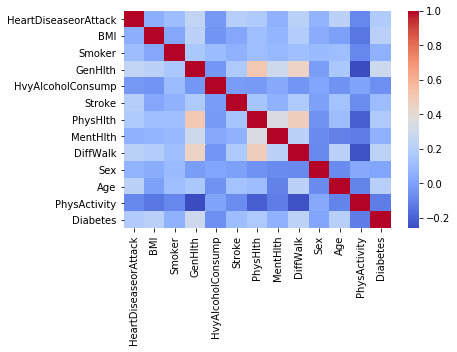

In [23]:
sns.heatmap(brfss_ml_2015.corr(), cmap='coolwarm')

## Age

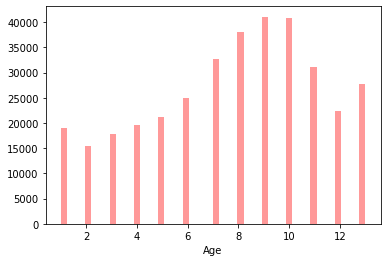

In [24]:
sns.distplot(brfss_ml_2015['Age'], kde=False, color='red')

## Sex / Smoker

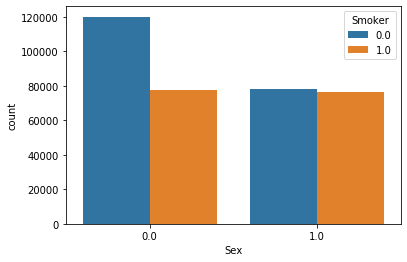

In [25]:
sns.countplot(x='Sex', data=brfss_ml_2015, hue='Smoker')

## Smoking / HDA

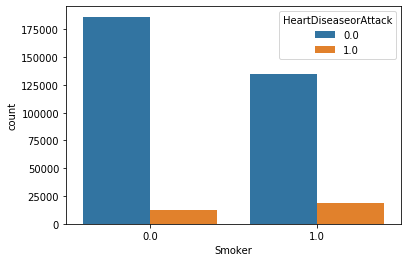

In [26]:
sns.countplot(x='Smoker', data=brfss_ml_2015, hue='HeartDiseaseorAttack')

## Smoking/Diabetes

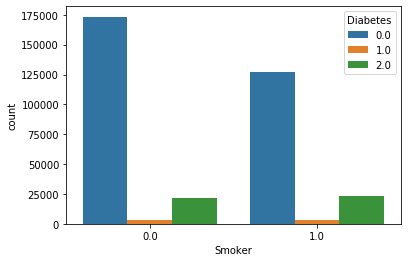

In [27]:
sns.countplot(x='Smoker', data=brfss_ml_2015, hue='Diabetes')

## Smoking / Stroke

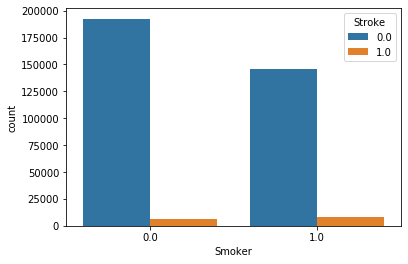

In [28]:
sns.countplot(x='Smoker', data=brfss_ml_2015, hue='Stroke')

## Diabetes / Sex

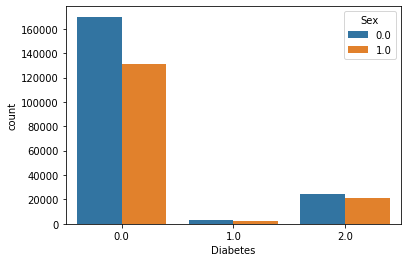

In [29]:
sns.countplot(x='Diabetes', data=brfss_ml_2015, hue='Sex')

## Physical Activity / Sex

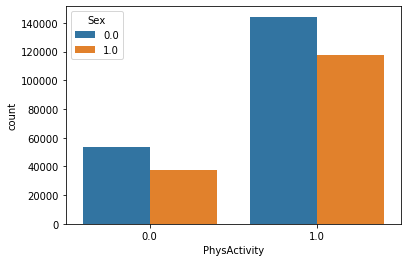

In [30]:
sns.countplot(x='PhysActivity', data=brfss_ml_2015, hue='Sex')

## Physical / HDA

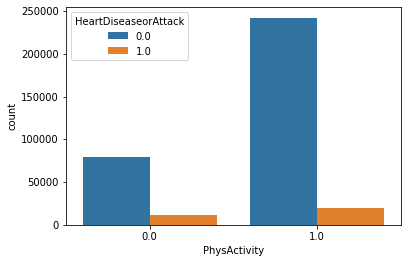

In [31]:
sns.countplot(x='PhysActivity', data=brfss_ml_2015, hue='HeartDiseaseorAttack')

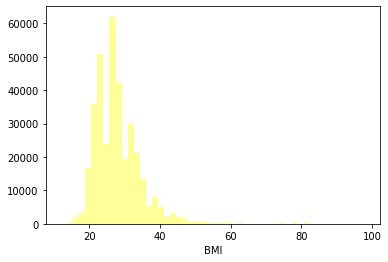

In [32]:
sns.distplot(brfss_ml_2015['BMI'], kde=False, color ='Yellow')

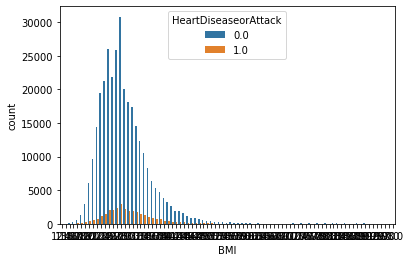

In [33]:
sns.countplot(x='BMI', data=brfss_ml_2015, hue='HeartDiseaseorAttack')

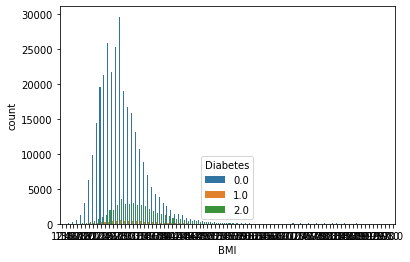

In [34]:
sns.countplot(x='BMI', data=brfss_ml_2015, hue='Diabetes')

## General Health / Sex

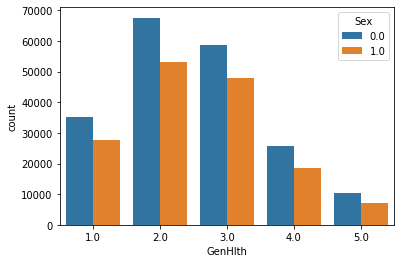

In [35]:
sns.countplot(x='GenHlth', data=brfss_ml_2015, hue='Sex')

## Genearl Health / HDA

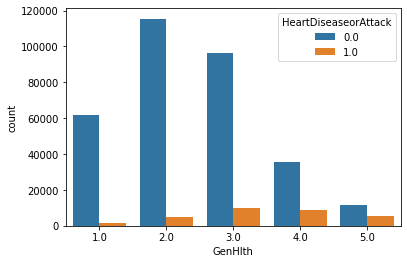

In [36]:
sns.countplot(x='GenHlth', data=brfss_ml_2015, hue='HeartDiseaseorAttack')

## General Health / HVC

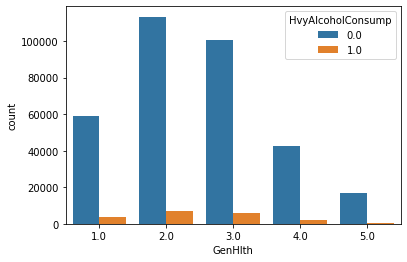

In [37]:
sns.countplot(x='GenHlth', data=brfss_ml_2015, hue='HvyAlcoholConsump')

# Model Building V2

In [38]:
X = brfss_ml_2015.drop(columns =['HeartDiseaseorAttack'], axis = 1)
Y = brfss_ml_2015['HeartDiseaseorAttack']

In [39]:
X_train, x_test, y_train, y_test = train_test_split(X,Y,shuffle = True, test_size = .2, random_state = 42 )
y_train.value_counts()

0.0    256891
1.0     24724
Name: HeartDiseaseorAttack, dtype: int64

In [40]:
ros = RandomOverSampler(random_state = 42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train , y_train)
y_train_resampled.value_counts()

1.0    256891
0.0    256891
Name: HeartDiseaseorAttack, dtype: int64

# Bernouli

              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     64111
         1.0       0.20      0.65      0.31      6293

    accuracy                           0.74     70404
   macro avg       0.58      0.70      0.58     70404
weighted avg       0.89      0.74      0.79     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


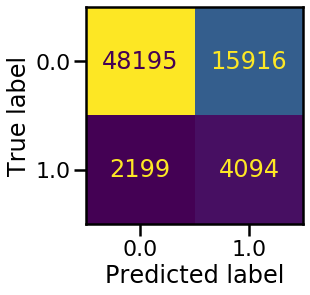

In [41]:
model_0 = BernoulliNB()
model_0.fit(X_train_resampled,y_train_resampled)
pred_0 = model_0.predict(x_test)
print(classification_report(y_test,pred_0))
cm = confusion_matrix(y_test,pred_0)
sns.set_context("poster") 
dispo = plot_confusion_matrix(model_0, x_test, y_test, colorbar= False)

# Gaussian



              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87     64111
         1.0       0.24      0.64      0.35      6293

    accuracy                           0.78     70404
   macro avg       0.60      0.72      0.61     70404
weighted avg       0.89      0.78      0.82     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


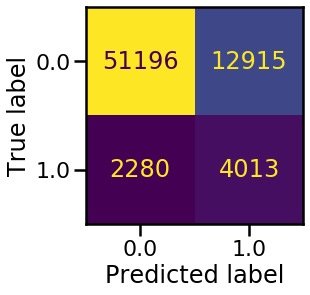

In [48]:
model_1 = GaussianNB()
model_1.fit(X_train_resampled,y_train_resampled)
pred_1 = model_1.predict(x_test)
print(classification_report(y_test,pred_1))
cm = confusion_matrix(y_test,pred_1)
sns.set_context ("poster") 
dispo = plot_confusion_matrix(model_1, x_test , y_test, colorbar= False)

# Random Forest

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     64111
         1.0       0.22      0.37      0.27      6293

    accuracy                           0.82     70404
   macro avg       0.58      0.62      0.59     70404
weighted avg       0.87      0.82      0.84     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


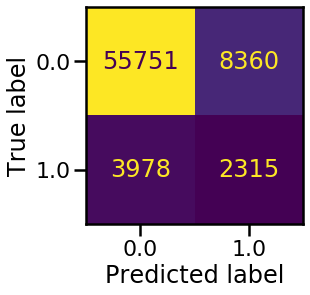

In [43]:
rf=RandomForestClassifier( n_estimators = 9 )
rf.fit(X_train_resampled , y_train_resampled)
y_pred_3 = rf.predict(x_test)
print(classification_report(y_test,y_pred_3))
from sklearn.metrics import  plot_confusion_matrix
sns.set_context ("poster") 
dispo = plot_confusion_matrix(rf, x_test , y_test, colorbar= False)

# Voting

BernoulliNB 0.6505641188622279
RandomForestClassifier 0.35531542984268233
GaussianNB 0.6376926744001271
VotingClassifier 0.6156046400762752
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88     64111
         1.0       0.25      0.62      0.35      6293

    accuracy                           0.80     70404
   macro avg       0.60      0.72      0.62     70404
weighted avg       0.89      0.80      0.83     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


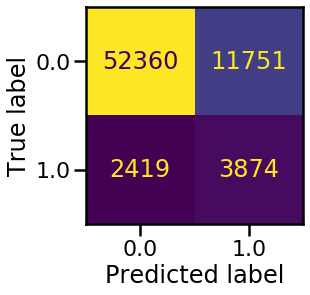

In [44]:
ber_clf = BernoulliNB()
rnd_clf = RandomForestClassifier()
gss_clf = GaussianNB()
voting_clf = VotingClassifier(
estimators=[('Bernoulli', ber_clf), ('rf', rnd_clf), ('gss', gss_clf)],
voting='hard')
voting_clf.fit(X_train_resampled,y_train_resampled)

for clf in (ber_clf, rnd_clf, gss_clf, voting_clf):
    clf.fit(X_train_resampled,y_train_resampled)
    y_pred_4 = clf.predict(x_test)
    print(clf.__class__.__name__, recall_score(y_test, y_pred_4))
print(classification_report(y_test,y_pred_4))
sns.set_context ("poster") 
dispo = plot_confusion_matrix(voting_clf, x_test, y_test, colorbar= False)

# Bagging

              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     64111
         1.0       0.22      0.82      0.35      6293

    accuracy                           0.72     70404
   macro avg       0.60      0.77      0.59     70404
weighted avg       0.91      0.72      0.78     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


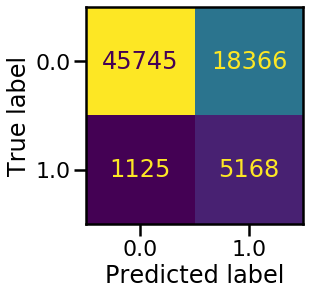

In [45]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500,
max_samples=150, bootstrap=False, n_jobs=-1)
bag_clf.fit(X_train_resampled,y_train_resampled)
y_pred_5 = bag_clf.predict(x_test)
print(classification_report(y_test,y_pred_5))
sns.set_context ("poster") 
dispo = plot_confusion_matrix(bag_clf, x_test , y_test, colorbar= False)

# XGBoost classifier

              precision    recall  f1-score   support

         0.0       0.97      0.72      0.83     64111
         1.0       0.22      0.80      0.35      6293

    accuracy                           0.73     70404
   macro avg       0.60      0.76      0.59     70404
weighted avg       0.91      0.73      0.79     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


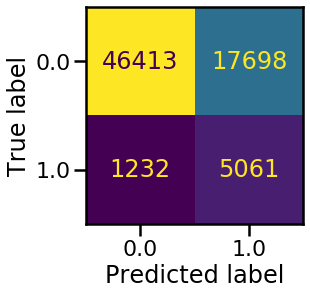

In [46]:
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':9
        }
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train_resampled,y_train_resampled)
y_pred_6 = xgb_clf.predict(x_test)
print(classification_report(y_test,y_pred_6))
sns.set_context ("poster") 
dispo = plot_confusion_matrix(xgb_clf, x_test, y_test, colorbar= False)

# Logistic Regression

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     64111
         1.0       0.24      0.78      0.36      6293

    accuracy                           0.75     70404
   macro avg       0.60      0.77      0.60     70404
weighted avg       0.91      0.75      0.80     70404



D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


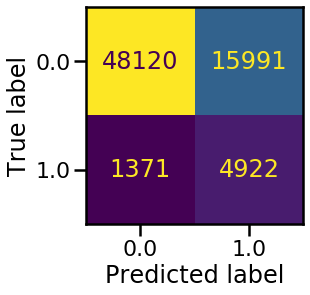

In [47]:
LR=LogisticRegression(max_iter=10000)
LR.fit(X_train_resampled, y_train_resampled)
y_pred_6 = LR.predict(x_test)
print(classification_report(y_test,y_pred_6))
sns.set_context ("poster") 
dispo = plot_confusion_matrix(LR, x_test, y_test, colorbar= False)